In [1]:
%run header_v.py
%matplotlib widget
import numpy_financial as npf

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import dateutil

class ddict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self


In [3]:
# Set up the initial properties for the solar system scenario
p = ddict(
    solar_system_cost = 250000,                     # Cost of the solar system
    eskom_rate = 2300,                              # Cost of power from Eskom
    solar_loan_interest_rate = 0.09,               # Interest rate of the solar loan
    solar_system_lifetime = 5 * 12,                 # Expected lifetime of the solar system in months
    simulation_period = 15 * 12 ,                    # Simulation period in months
    investment_interest = 0.075,                    # Value on investments
    inf_rate = 0.10,                               # General rate of inflation
    savings_ESK = 0,                                    # Initial savings
    savings_FD_used = 0,                              # This is for the scenario where we use our savings instead
    savings_FD_unused = 250000,                            # This is for the scenario where we use our savings instead
    savings_solar_int = 0                            # 
    
)

# Calculate the monthly payments for the solar system
p.solar_loan_payment = -npf.pmt(p.solar_loan_interest_rate/12, p.solar_system_lifetime, p.solar_system_cost)
p.npf = p.solar_loan_payment

prev = None
lst = []

# Loop through each month of the simulation
for i in range(p.simulation_period):
    # If this is the first month, use the initial properties
    if not prev:
        curr = ddict(**p)
        curr.date = pd.Timestamp('2023/08/01')
        curr.solar_loan_amount = curr.solar_system_cost
        curr.potential_eskom_payment = 0  # Initiate the potential Eskom payment
    else:
        # Otherwise, use the properties from the previous month
        curr = ddict(**prev) 
        curr.date = curr.date + pd.DateOffset(months=1)

    # Increase the Eskom rate by the inflation rate each year
    if i%12==0 and i!=0:     
        curr.eskom_rate = curr.eskom_rate*(1+curr.inf_rate)

    # Calculate the new solar loan amount and monthly payments
    # After the repayment period, set the solar loan payment to zero
    if i < p.solar_system_lifetime:
        curr.solar_loan_interest = curr.solar_loan_amount*(curr.solar_loan_interest_rate/12)
        curr.solar_loan_amount = curr.solar_loan_amount + curr.solar_loan_interest - curr.solar_loan_payment
        curr.solar_loan_payment = min(p.solar_loan_payment, curr.solar_loan_amount)
    else:
        curr.solar_loan_payment = 0
        curr.potential_eskom_payment = curr.eskom_rate  # Record the potential Eskom payment after the solar loan is paid off

    # Calculate the costs under the solar and Eskom scenarios
    curr.solar_cost = curr.solar_loan_payment
    curr.eskom_cost = curr.eskom_rate
    
    curr.interest_savings_solar = curr.savings_solar_int * curr.investment_interest/12
    curr.savings_solar_int = curr.savings_solar_int + curr.interest_savings_solar 
    

    # Calculate the potential investments under the Eskom scenario and update the savings
    curr.investment = max(curr.eskom_cost - curr.solar_cost, 0)
    curr.savings_ESK = curr.savings_ESK * (1 + curr.investment_interest/12) + curr.investment
    
    # Calulate the interest gained if I was using fixed deposit moneies and not a loan. 
    # And then rather placing the same money (for a loan) back into the fixed deposit.

    curr.save_FD_payment = max(p.npf, curr.eskom_rate)

    # Calculate interest for the 'used' savings and update the savings
    curr.interest_earned_used = curr.savings_FD_used * curr.investment_interest/12
    curr.savings_FD_used = curr.savings_FD_used + curr.interest_earned_used + curr.save_FD_payment

    # Calculate interest for the 'unused' savings and update the savings
    curr.interest_earned_unused = curr.savings_FD_unused * curr.investment_interest/12
    curr.savings_FD_unused = curr.savings_FD_unused + curr.interest_earned_unused

    # Calculate the cost of using savings in terms of lost interest
    curr.fixed_deposit_cost = curr.interest_earned_unused - curr.interest_earned_used

    
    # Store the properties for this month
    lst.append(curr)
    prev = curr

# Convert the list of monthly properties to a DataFrame and store it
data = pd.DataFrame(lst)


In [4]:
# data

In [5]:
# Function to add a space between every third digit
def add_space_between_digits(number):
    number_str = f"{number:,.0f}"
    return number_str.replace(",", " ")

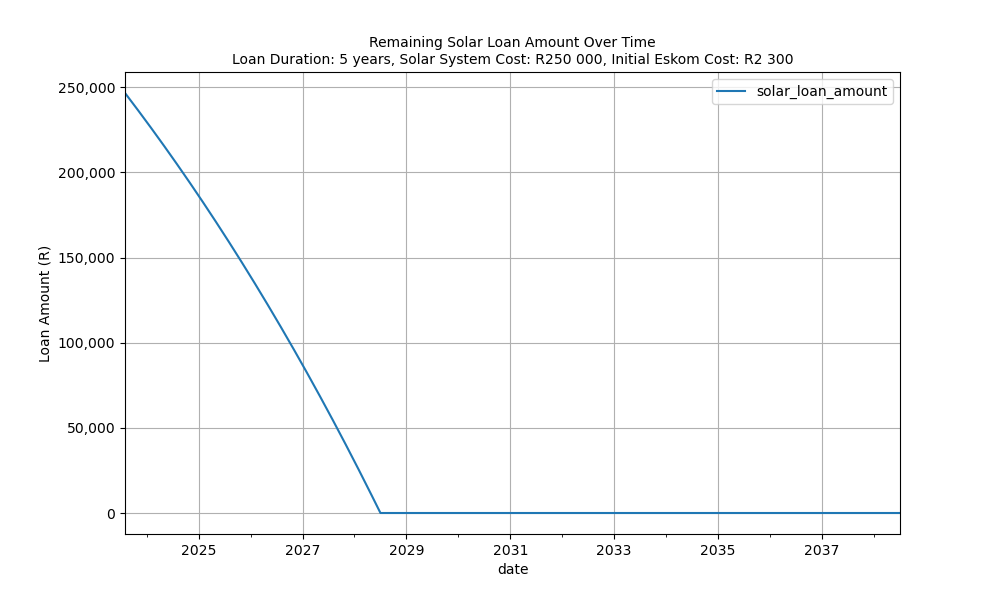

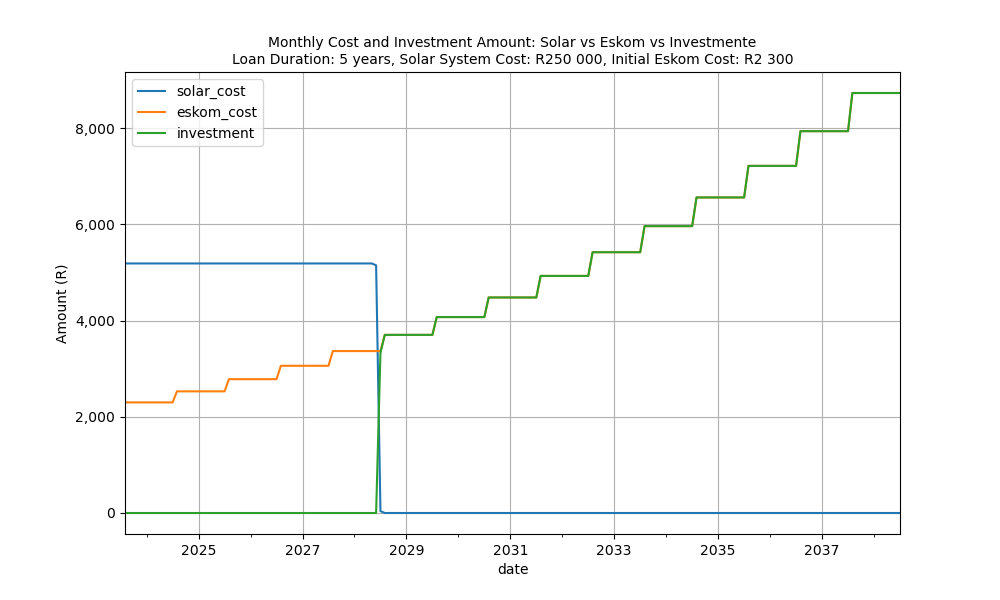

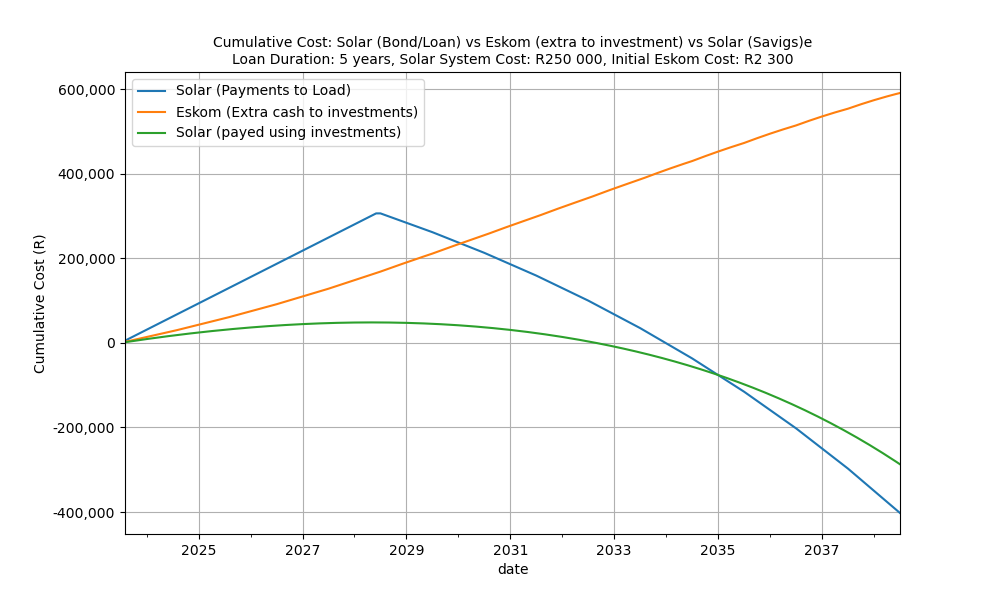

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


# Calculate cumulative potential Eskom payments and cumulative investment payments
data['cumulative_potential_eskom_payment'] = data['potential_eskom_payment'].cumsum()
data['cumulative_interest_savings_solart'] = data['interest_savings_solar'].cumsum()
data['cumulative_investment_payments'] = data['investment'].cumsum()
data['cumulative_eskom_cost'] = data['eskom_cost'].cumsum()
data['cumulative_solar_cost'] = data['solar_cost'].cumsum()
data['cumulative_fixed_deposit_cost'] = data['fixed_deposit_cost'].cumsum()

loan_years = p.solar_system_lifetime // 12
solar_cost = p.solar_system_cost
initial_eskom_cost = p.eskom_rate


# Calculate the combined Eskom and investment payments minus savings
data['combined_eskom_investment_minus_savings_ESK'] = data['cumulative_eskom_cost'] + data['cumulative_investment_payments'] - data['savings_ESK']

# Adjust the cumulative solar cost by subtracting cumulative potential Eskom payments
data['Adjusted_cumulative_solar_cost'] = data['cumulative_solar_cost'] - data['cumulative_potential_eskom_payment'] - data['cumulative_interest_savings_solart']

fig1, ax1 = plt.subplots(figsize=(10, 6), sharex=True)
fig2, ax2 = plt.subplots(figsize=(10, 6), sharex=True)
fig3, ax3 = plt.subplots(figsize=(10, 6), sharex=True) # For the cumulative payment graph
# fig4, ax4 = plt.subplots(figsize=(10, 6), sharex=True)

# Plot the remaining solar loan amount
data.plot(x='date', y='solar_loan_amount', ax=ax1)
ax1.set_title(f'Remaining Solar Loan Amount Over Time\nLoan Duration: {loan_years} years, Solar System Cost: R{add_space_between_digits(solar_cost)}, Initial Eskom Cost: R{add_space_between_digits(initial_eskom_cost)}', fontsize = 10)
ax1.set_ylabel('Loan Amount (R)')
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  
ax1.grid(True)  # add grid


# Plot the cost comparison between solar and Eskom and investment
data.plot(x='date', y=['solar_cost', 'eskom_cost', 'investment'], ax=ax2)
ax2.set_title(f'Monthly Cost and Investment Amount: Solar vs Eskom vs Investmente\nLoan Duration: {loan_years} years, Solar System Cost: R{add_space_between_digits(solar_cost)}, Initial Eskom Cost: R{add_space_between_digits(initial_eskom_cost)}', fontsize = 10)
ax2.set_ylabel('Amount (R)')
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  
ax2.grid(True)  # add grid

# Plot the cumulative cost comparison between solar and Eskom and investment
data.plot(x='date', y='Adjusted_cumulative_solar_cost', ax=ax3, label='Solar (Payments to Load)')
data.plot(x='date', y='combined_eskom_investment_minus_savings_ESK', ax=ax3, label='Eskom (Extra cash to investments)')
data.plot(x='date', y='cumulative_fixed_deposit_cost', ax=ax3, label='Solar (payed using investments)')
ax3.set_title(f'Cumulative Cost: Solar (Bond/Loan) vs Eskom (extra to investment) vs Solar (Savigs)e\nLoan Duration: {loan_years} years, Solar System Cost: R{add_space_between_digits(solar_cost)}, Initial Eskom Cost: R{add_space_between_digits(initial_eskom_cost)}', fontsize = 10)
ax3.set_ylabel('Cumulative Cost (R)')
ax3.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  
ax3.grid(True)  # add grid

# # Plot the savings over time
# data.plot(x='date', y='savings_ESK', ax=ax4)
# ax4.set_title(f'Accumulated Savings from Eskom Over Timee\nLoan Duration: {loan_years} years, Solar System Cost: R{add_space_between_digits(solar_cost)}, Initial Eskom Cost: R{add_space_between_digits(initial_eskom_cost)}', fontsize = 10)
# ax4.set_ylabel('Savings (R)')
# ax4.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))) 
# ax4.grid(True)  # add grid




fig1.savefig('solar_loan.png', dpi=150)
fig2.savefig('cost_comparison.png', dpi=150)
fig3.savefig('cumulative_cost_comparison.png', dpi=150)
# fig4.savefig('savings_ESK.png', dpi=150)

fig1.show() # Display the plots
fig2.show() # Display the plots
fig3.show() # Display the plots
# fig4.show() # Display the plots


In [7]:
# # Sum of all solar costs and Eskom costs at the end of the simulation
# total_solar_cost = data['solar_cost'].sum()
# total_eskom_cost = data['eskom_cost'].sum()

# # Fetch the final total savings
# total_savings = data['savings'].iloc[-1]

# # Calculate the total Eskom payments made over the simulation period
# total_eskom_payments = data['eskom_cost'].sum()

# # Here we use 'investment' instead of 'savings' to calculate total_investment_payments
# # This is the total amount paid towards the solar system investment over the simulation period
# total_investment_payments = data['investment'].sum()

# # Calculate the net Eskom cost over the simulation period by subtracting the total Eskom costs and investment payments from the total savings
# total_net_eskom_cost = total_savings - total_eskom_cost - total_investment_payments



# # Print the results with "R" symbol and space between every third digit
# print(f"Total expenditure for Solar over {p.solar_system_lifetime / 12} years: R{add_space_between_digits(total_solar_cost)}")
# print(f"Total expenditure for Eskom over {p.solar_system_lifetime / 12} years: R{add_space_between_digits(total_eskom_cost)}")
# print(f"Total net loss using Eskom over {p.solar_system_lifetime / 12} years: R{add_space_between_digits(total_net_eskom_cost)}")



# # The following lines are commented out, so they will not be executed and printed:
# # print(f"Total savings over {p.simulation_period / 12} years: {total_savings}")
# # print(f"Total payments to Eskom over {p.simulation_period / 12} years: {total_eskom_payments}")
# # print(f"Total payments to the investment over {p.simulation_period / 12} years: {total_investment_payments}")
